_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pandas_profiling

from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [167]:
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [168]:
trainval_store_id = train['Store'].unique()
train_store_id, val_store_id = train_test_split(trainval_store_id, random_state=9)

train_split = train[train.Store.isin(train_store_id)]
val_split = train[train.Store.isin(val_store_id)]

In [169]:
def prepare(X):
    X = X.copy()
    X = X.merge(store, on='Store')
    X['Date'] = pd.to_datetime(X['Date'])
    X['Year'] = X['Date'].dt.year
    X['Month'] = X['Date'].dt.month
    X['Day'] = X['Date'].dt.day
    y = np.log1p(X['Sales'])
    X = X.drop(columns=['Sales','Date'])
    return X, y

In [170]:
X_train, y_train = prepare(train_split)

In [171]:
X_val, y_val = prepare(val_split)

In [172]:
X_test, y_test = prepare(test)

In [173]:
pandas_profiling.ProfileReport(X_train)

Number of variables,17
Number of observations,58800
Total Missing (%),16.5%
Total size in memory,8.1 MiB
Average record size in memory,144.0 B
Numeric,11
Categorical,3
Boolean,3
Date,0
Text (Unique),0
Rejected,0


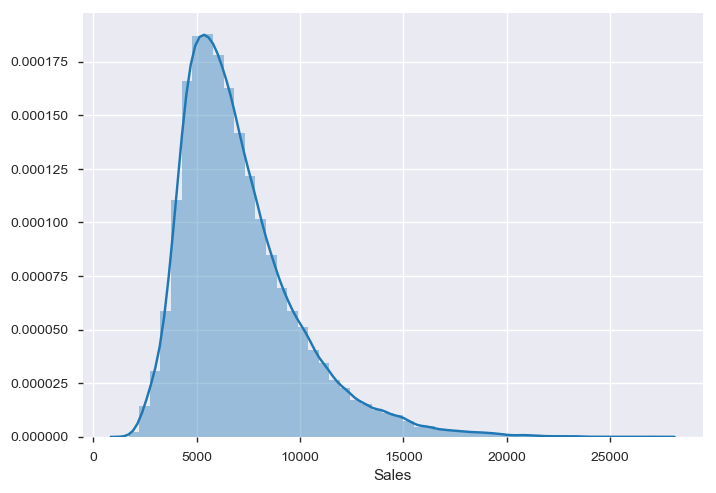

In [174]:
sns.distplot(np.expm1(y_train))

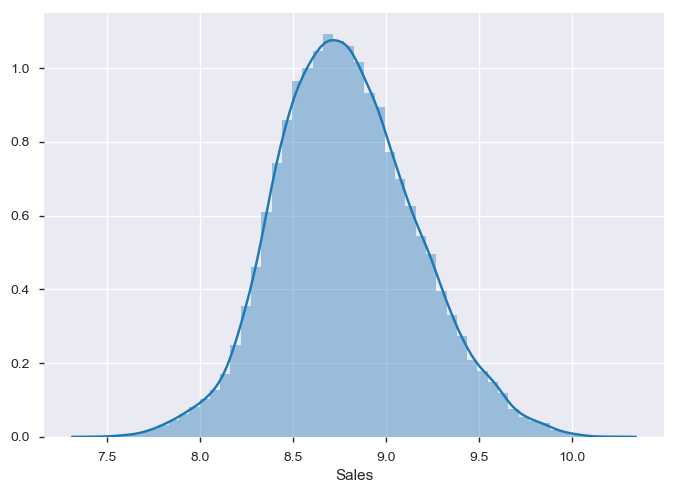

In [175]:
sns.distplot(y_train)

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all rows for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all rows for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all rows for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [176]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train,
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=20)

[0]	validation_0-rmse:7.46968	validation_1-rmse:7.43121
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.72334	validation_1-rmse:6.68935
[2]	validation_0-rmse:6.05164	validation_1-rmse:6.02167
[3]	validation_0-rmse:5.44714	validation_1-rmse:5.42256
[4]	validation_0-rmse:4.90309	validation_1-rmse:4.88328
[5]	validation_0-rmse:4.41352	validation_1-rmse:4.3982
[6]	validation_0-rmse:3.9729	validation_1-rmse:3.96172
[7]	validation_0-rmse:3.57642	validation_1-rmse:3.5703
[8]	validation_0-rmse:3.21963	validation_1-rmse:3.21649
[9]	validation_0-rmse:2.89856	validation_1-rmse:2.89868
[10]	validation_0-rmse:2.60967	validation_1-rmse:2.61152
[11]	validation_0-rmse:2.34974	validation_1-rmse:2.35408
[12]	validation_0-rmse:2.11586	validation_1-rmse:2.12407
[13]	validation_0-rmse:1.90546	validation_1-rmse:1.91585
[14]	validation_0-rmse:1.71619	validation_1-rmse:1.72852

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [178]:
results = model.evals_result()

results['validation_1']['rmse'][94]

0.135073

In [179]:
X_test_encoded = encoder.transform(X_test)

y_pred = model.predict(X_test_encoded)

In [180]:
sqrt(mean_squared_error(y_test, y_pred))

0.14329557393094328

In [182]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1


In [186]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(random_state=9))

param_distributions = {
    'randomforestregressor__n_estimators': randint(50,500),
    'randomforestregressor__max_features': uniform(),
    'randomforestregressor__min_samples_leaf': [1,10,100]}

groups = X_train['Store']

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train.fillna(0), y_train, groups=groups);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    6.2s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   13.8s remaining:   32.1s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:   21.4s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   22.3s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   24.7s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   29.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   42.7s finished


In [187]:
search.best_params_, np.sqrt(-search.best_score_)

({'randomforestregressor__max_features': 0.46970669512916075,
  'randomforestregressor__min_samples_leaf': 1,
  'randomforestregressor__n_estimators': 355},
 0.19076164893329092)

## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [ ]:
def score(X, y):
    y_pred = model.predict(X)
    return accuracy(y, y_pred)

base_score, score_decreases = get_score_importances(score, X, y)
feature_importances = np.mean(score_decreases, axis=0)

In [88]:
X_val_altered = X_val_encoded.fillna(0)

In [99]:
permuter = PermutationImportance(model, scoring='neg_mean_squared_error',
                                cv='prefit', n_iter=30, random_state=9)

permuter.fit(X_val_altered, y_val)
features = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=features)

Weight,Feature
0.2174 ± 0.0035,Customers
0.0092 ± 0.0003,Promo
0.0018 ± 0.0001,StoreType
0.0014 ± 0.0000,Promo2SinceWeek
0.0011 ± 0.0001,Month
0.0009 ± 0.0001,DayOfWeek
0.0009 ± 0.0001,PromoInterval
0.0008 ± 0.0001,Assortment
0.0007 ± 0.0000,Day
0.0003 ± 0.0000,Year


In [93]:
features[9]

'CompetitionOpenSinceYear'

In [90]:
mask = permuter.feature_importances_ > 0

mask

array([False,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True, False,  True,  True,  True,  True])

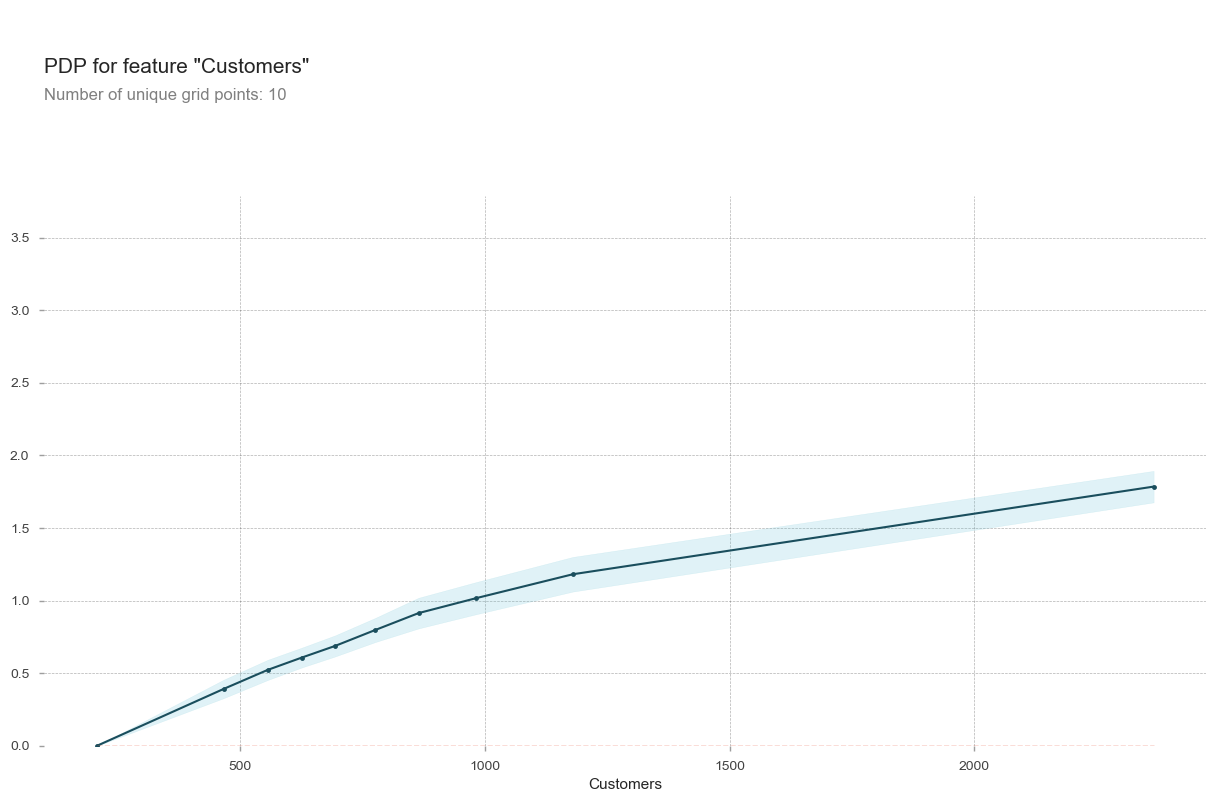

In [96]:
feature = 'Customers'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

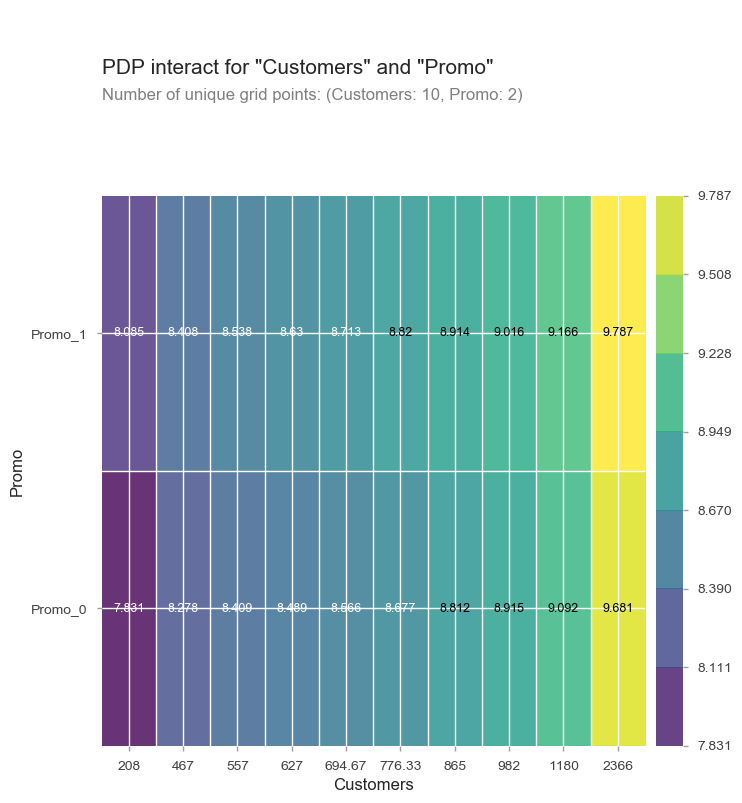

In [101]:
features = ['Customers','Promo']

interaction = pdp_interact(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);